In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import shapely.wkt
import pyproj
from pyproj import Geod
import shapely
from shapely.geometry import box, Polygon, Point
from shapely.ops import orient
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import multiprocessing as mp

## Preprocessing/load in variables

In [2]:
all_res = pd.read_csv('/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/outputs/Strata/sj_parcels_bins.csv')

In [3]:
sample_all = pd.read_csv('/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/CloudFactory/Iteration3/complete_sampled_APNs.csv')
sample = pd.read_csv('/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/CloudFactory/Iteration3/sampled_APNs.csv')

In [4]:
part1 = sample.loc[:5000]

In [5]:
neyman = pd.concat([all_res['Bin'].value_counts().rename('all'), 
           part1['Bin'].value_counts().rename('sample')], axis=1).reset_index()

In [6]:
neyman = pd.concat([all_res['Bin'].value_counts().rename('all'), 
           part1['Bin'].value_counts().rename('sample')], axis=1).reset_index()

In [7]:
neyman['sample'] = neyman['sample'].fillna(0)
neyman['proportion_all_res'] = neyman['all']/neyman['all'].sum()
neyman['random_5k'] = round(neyman['proportion_all_res']*5000)
# percent change random to neyman
neyman['perc_change'] = (neyman['sample'] - neyman['random_5k'])/neyman['random_5k']*100
change = min(neyman['perc_change'])
max_n = round(neyman['sample'].sum()*(1+change/100)) # max n we can subsample to simulate a SRS

## helper functions

In [9]:
def make_global(bins_all_res, bins_sample, high_income_threshold, merged):
    global bins_all_res_global
    global high_income_threshold_global
    global merged_global
    global bins_sample_global

    bins_all_res_global = bins_all_res
    high_income_threshold_global = high_income_threshold
    merged_global = merged
    bins_sample_global = bins_sample

In [34]:
def driver(i):
    bin_n = bins_all_res_global['Bin'].value_counts()
    bin_sample_n = bins_sample_global['Bin'].value_counts()
    unique_bins = list(bins_all_res_global['Bin'].unique())
    sampled_unique_bins = list(bins_sample_global['Bin'].unique())
    
    results = {}
    results_df = pd.DataFrame(columns=['bin', 'year', 't', 'ybar', 'N', 'n', 'var', 'tot_var', 'high'])
    for year in ['2016', '2020']:

        t_dic = {'total': 0, 'high': 0, 'low': 0}
        total_var_dic = {'total': 0, 'high': 0, 'low': 0}

        for b in unique_bins:
            if b in sampled_unique_bins: # we drop 2 bins
                high_income = False
                income = b.split('_')[1].split('-')[0]
                if income != 'MISSING':
                    if int(income) > high_income_threshold_global:
                        high_income = True

                # SAMPLE WITH REPLACEMENT HERE
                np.random.seed((os.getpid() * int(time.time())) % 123456789)
#                 np.random.seed(i)
                bootstrap = bins_sample_global[bins_sample_global['Bin'] == b].sample(frac=1.0, replace=True)
                value_counts = bootstrap['APN'].value_counts()

                overlap = list(set(bootstrap['APN'].unique()) & set(merged_global['APN'].unique()))
                overlap_counts = value_counts.loc[overlap]
                sub = pd.DataFrame(columns=merged_global.columns)

                for idx, val in overlap_counts.iteritems():
                    for i in range(val):
                        sub.loc[len(sub)] = merged_global[merged_global['APN'] == idx].iloc[0].tolist()

#                 sub = merged[merged['Bin'] == b].sample(frac=x, replace=True)
                sub[year] = sub[year].apply(lambda x: 1 if not pd.isna(x) else 0)
                sub = sub[[year, 'APN']].groupby('APN').agg(list)
                sub[year] = sub[year].apply(lambda x: np.sum(x))

                n_j = bin_sample_n[b]
                N_j = bin_n[b]

                y_avg_j = sub[year].sum()/n_j
                t_j = N_j*y_avg_j
                if n_j == 1:
                    n_j += 1 # safeguard against div by 0 error
                var_j = np.sum(np.square(np.array(sub[year].tolist() + \
                                              [0] * (n_j-len(sub))) - y_avg_j)) / (n_j - 1)
                total_var_j = (1-(n_j/N_j))*N_j*N_j*(var_j/n_j)

                t_dic['total'] += t_j
                total_var_dic['total'] += total_var_j

                results_df.loc[len(results_df)] = [b, year, t_j, y_avg_j, N_j, n_j, var_j, total_var_j, high_income]
                inc = None
                if income != 'MISSING':
                    if high_income:
                        inc = 'high'
                        t_dic['high'] += t_j
                        total_var_dic['high'] += total_var_j
                    else:
                        inc = 'low'
                        t_dic['low'] += t_j
                        total_var_dic['low'] += total_var_j


        results[year] = {'t': t_dic, 'var': total_var_dic}

    t_2020 = results['2020']['t']['high']
    t_2016 = results['2016']['t']['high']

    high_change = (t_2020-t_2016)/(t_2016)

    t_2020 = results['2020']['t']['low']
    t_2016 = results['2016']['t']['low']

    low_change = (t_2020-t_2016)/(t_2016)

    return (results['2020']['t']['total'] - results['2016']['t']['total'], low_change - high_change)

In [11]:
def bootstrap_mp(subset, bins_all_res, bins_sample, high_income_threshold, n):
    
    merged = subset[['apn', '2016', '2020']].merge(bins_all_res, left_on='apn', 
                                                   right_on='APN', how='left').drop(columns=['apn'])
    
    nprocs = mp.cpu_count()

    p = mp.Pool(processes=nprocs, initializer=make_global, 
                initargs=(bins_all_res, bins_sample, high_income_threshold, merged, ))
    
#     result = p.map(driver, range(n))
    
    result = []
    for x in tqdm(p.imap_unordered(driver, range(n)), total=n):
        result.append(x)
    
    diff_n = [i[0] for i in result]
    perc_change = [i[1] for i in result]
    
    return diff_n, perc_change
    
#     with open(os.path.join(fp_out, "bootstrap_q1.p"), "wb") as output_file:
#         pickle.dump(diff_n, output_file)

#     with open(os.path.join(fp_out,  "bootstrap_q2.p"), "wb") as output_file:
#         pickle.dump(perc_change, output_file)

In [15]:
def two_sided_test(l, p):
    l.sort()
    ci = [l[int(p/2*len(l))], l[len(l) - int(p/2*len(l))]]
    mean = np.mean(l)
    return mean, ci

In [10]:
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs/Population-Estimates/outputs/')
cf_fp = '/oak/stanford/groups/deho/building_compliance/CloudFactory/'
POP_OUTPUT = '/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/'

In [30]:
df_processed = pd.read_csv(os.path.join(cf_fp, 'results', 'Batch3_part1', 'processed_buildings.csv'), 
                           dtype={'apn': str})
bins_all_res = pd.read_csv(os.path.join(OAK_FP, 'outputs/Population-Estimates/outputs/Strata/sj_parcels_bins.csv'))
# sample_all = pd.read_csv('/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/CloudFactory/Iteration3/complete_sampled_APNs.csv')
sample = pd.read_csv('/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/CloudFactory/Iteration3/sampled_APNs.csv')
part1 = sample.loc[:5000]

# filter by size
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:26910')
project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
df_processed['2016_a'] = df_processed['2016'].apply(lambda x: shapely.ops.transform(project, shapely.wkt.loads(x)).area if not pd.isna(x) else x)
df_processed['2020_a'] = df_processed['2020'].apply(lambda x: shapely.ops.transform(project, shapely.wkt.loads(x)).area if not pd.isna(x) else x)

subset = df_processed[(df_processed['2016_a'] >= 11.15) | (df_processed['2020_a'] >= 11.15)]

In [31]:
high_income_threshold = 37.5
n = 5000

### 0. Model Inferences

In [48]:
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'

BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')

In [54]:
inference_2016 = gpd.read_file(BUILD_FP.format('2016'))
inference_2020 = gpd.read_file(BUILD_FP.format('2020'))

In [53]:
inference_2016['small'].sum()

59238

In [55]:
inference_2020['small'].sum()

65119

## a) Run once -- DON'T RUN THIS AGAIN. Nothing to do with subsampling

Neyman run

In [35]:
diff_n, perc_change = bootstrap_mp(subset, bins_all_res, part1, high_income_threshold, n)

100%|██████████| 5000/5000 [1:29:41<00:00,  1.08s/it]  


In [36]:
with open(os.path.join(POP_OUTPUT, 'final', 'ney1_q1.p'), 'wb') as f:
    pickle.dump(diff_n, f)
    
with open(os.path.join(POP_OUTPUT, 'final', 'ney1_q2.p'), 'wb') as f:
    pickle.dump(perc_change, f)

In [39]:
two_sided_test(diff_n, 0.05)

(2000.2222353395314, [8.791037790528208, 4028.025148923829])

In [40]:
two_sided_test(perc_change, 0.05)

(0.025143555556075527, [-0.17305419467401215, 0.21141359556905362])

load in srs previously run

In [46]:
with open(os.path.join(POP_OUTPUT, 'final', 'bootstrap_q1.p'), 'rb') as f:
    diff_n_srs = pickle.load(f)
    
with open(os.path.join(POP_OUTPUT, 'final', 'bootstrap_q2.p'), 'rb') as f:
     perc_change_srs = pickle.load(f)

In [44]:
two_sided_test(diff_n_srs, 0.05)

(1121.6032564911718, [-446.9124315721929, 2735.798511360339])

In [47]:
two_sided_test(perc_change_srs, 0.05)

(0.05687604300227142, [-0.14322043159951736, 0.24560892254582983])

In [45]:
two_sided_test(perc_change_srs, 0.05)

(0.05687604300227142, [-0.14322043159951736, 0.24560892254582983])

## b) Run w subsampling
- n: number of times to bootstrap (reduce this to <1000. it will take way too long otherwise)
- max_n (calculated in one of the earliest cells): max samples we can have to generate a stratified random sample (this will be our upper limit on subsampling)
- runs: number of times we take a particular subsample -- so basically for each run, we take n bootstrap samples. this is important because subsampling, say, 800 of 5000 will lead to very high variance, so i wanted to see how much the estimates differ when we subsample 5 times, and do bootstrapping on those 5 samples

In [19]:
high_income_threshold = 37.5
n = 5000 # number of times to bootstrap
runs = 5

In [15]:
n_sample_list = [int(i) for i in np.linspace(800, max_n, 5)]

In [12]:
fp_out_srs = os.path.join(POP_OUTPUT, 'final', 'test', 'srs')
fp_out_ney = os.path.join(POP_OUTPUT, 'final', 'test', 'neyman')

if not os.path.exists(fp_out_srs):
    os.makedirs(fp_out_srs)
if not os.path.exists(fp_out_ney):
    os.makedirs(fp_out_ney)

In [ ]:
q1_neyman = {}
q1_srs = {}
q2_neyman = {}
q2_srs = {}

for o in [q1_neyman, q1_srs, q2_neyman, q2_srs]:
    for i in n_sample_list:
        o[i] = {}
        for j in range(1, 6):
            o[i][j] = []

In [ ]:
for n_sample in tqdm(n_sample_list, position=0, desc="n_sample", leave=False):
    for r in tqdm(range(1, runs+1), position=1, desc="r", leave=False):
        ## ---- SAMPLING FOR BOTH METHODS ----
        neyman_sample = part1.sample(n_sample)
        random_sample = pd.DataFrame(columns=part1.columns)
        # re-calculate random_subsampled depending on n
        neyman['random_subsampled'] = round(neyman['proportion_all_res'] * n_sample)

        assert all(neyman['random_subsampled'] <= neyman['sample'])
        
        for idx, row in neyman.iterrows():
            b = row['index']
            sample_n = int(row['random_subsampled'])

            random_sample = pd.concat([random_sample, part1[part1['Bin'] == b].sample(sample_n)], ignore_index=True)
        
        ## ---- BOOTSTRAPPING ----
        # neyman 
        diff_n, perc_change = bootstrap_mp(subset, bins_all_res, neyman_sample, high_income_threshold, n)
        q1_neyman[n_sample][r] = diff_n
        q2_neyman[n_sample][r] = perc_change
        
        for i, j in zip([q1_neyman, q2_neyman], ['q1.p', 'q2.p']):
            with open(os.path.join(fp_out_ney, j), 'wb') as f:
                pickle.dump(i, f)
        
        # stratified random sample
        diff_n, perc_change = bootstrap_mp(subset, bins_all_res, random_sample, high_income_threshold, n)
        q1_srs[n_sample][r] = diff_n
        q2_srs[n_sample][r] = perc_change
        
        for i, j in zip([q1_srs, q2_srs], ['q1.p', 'q2.p']):
            with open(os.path.join(fp_out_srs, j), 'wb') as f:
                pickle.dump(i, f)

In [13]:
if os.path.exists(os.path.join(fp_out_srs, 'q1.p')):
    with open(os.path.join(fp_out_srs, 'q1.p'), 'rb') as f:
        q1_srs = pickle.load(f)
        
if os.path.exists(os.path.join(fp_out_ney, 'q1.p')):
    with open(os.path.join(fp_out_ney, 'q1.p'), 'rb') as f:
        q1_neyman = pickle.load(f)
        
if os.path.exists(os.path.join(fp_out_srs, 'q2.p')):
    with open(os.path.join(fp_out_srs, 'q2.p'), 'rb') as f:
        q2_srs = pickle.load(f)
        
if os.path.exists(os.path.join(fp_out_ney, 'q2.p')):
    with open(os.path.join(fp_out_ney, 'q2.p'), 'rb') as f:
        q2_neyman = pickle.load(f)

In [17]:
results = pd.DataFrame(columns=['q', 'method', 'sample_n', 'run', 'lb', 'mean', 'ub'])
for q, method, dic in zip([1, 1, 2, 2], ['srs', 'neyman', 'srs', 'neyman'],
               [q1_srs, q1_neyman, q2_srs, q2_neyman]):
    for i in dic.keys():
        for j in range(1, runs+1):
            mean, ci = two_sided_test(dic[i][j], 0.05)
            results.loc[len(results)] = [q, method, i, j, ci[0], mean, ci[1]]

In [36]:
results['err'] = results['ub']-results['mean']

In [75]:
grouped = results.groupby(['q', 'method', 'sample_n']).agg('mean').reset_index()

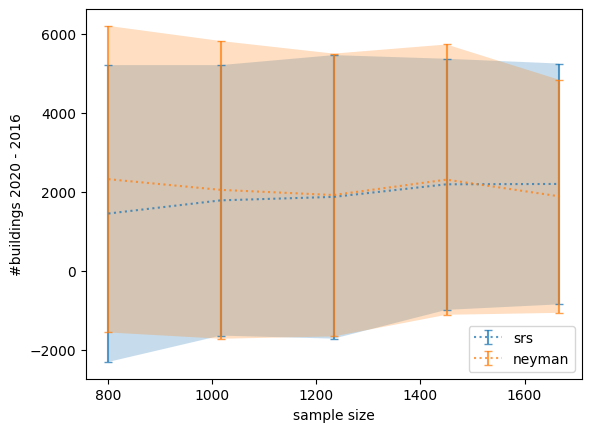

In [80]:
for m in ['srs', 'neyman']:
    subset = grouped[(grouped['q'] == 1) & (grouped['method'] == m)]
    
    plt.errorbar(subset['sample_n'], subset['mean'],
                 yerr = subset['err'], alpha=.75, fmt=':', capsize=3, capthick=1, label=m)
    data = {
        'x': list(subset['sample_n']),
        'y1': [y - e for y, e in zip(subset['mean'], subset['err'])],
        'y2': [y + e for y, e in zip(subset['mean'], subset['err'])]}
    plt.fill_between(**data, alpha=.25)

plt.xlabel('sample size')
plt.ylabel('#buildings 2020 - 2016')
plt.legend()
plt.show()

In [24]:
for dic in [q1_srs, q1_neyman, q2_srs, q2_neyman]:
    for i in dic.keys():
        for j in range(1, 6):
            if len(dic[i][j]) == 0:
                print(i)